In [1]:
import os
import json
import numpy as np
from quinine import QuinineArgumentParser
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys
sys.path.append('../scripts')
from nano_gpt import GPT2Model, GPT2Config

from utils import aggregate_metrics, get_model, eval_unlooped_model, eval_looped_model

In [2]:
device = torch.device('cuda:0')

In [3]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

## Get dataset

In [4]:
class DecisionTree():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, depth=4):
        self.n_dims = n_dims
        self.n_dims_truncated = n_dims_truncated
        self.b_size = batch_size
        self.n_points = n_points
        self.depth = depth

        # We represent the tree using an array (tensor). Root node is at index 0, its 2 children at index 1 and 2...
        # dt_tensor stores the coordinate used at each node of the decision tree.
        # Only indices corresponding to non-leaf nodes are relevant
        self.dt_tensor = torch.randint(
            low=0, high=n_dims, size=(batch_size, 2 ** (depth + 1) - 1)
        )

        # Target value at the leaf nodes.
        # Only indices corresponding to leaf nodes are relevant.
        self.target_tensor = torch.randn(self.dt_tensor.shape)

        self.xs = torch.randn(batch_size, n_points, n_dims).to(device)  # [B, n, d]
        self.ys = self.evaluate(self.xs)

    def evaluate(self, xs_b):
        dt_tensor = self.dt_tensor.to(xs_b.device)
        target_tensor = self.target_tensor.to(xs_b.device)
        ys_b = torch.zeros(xs_b.shape[0], xs_b.shape[1], device=xs_b.device)
        for i in range(xs_b.shape[0]):
            xs_bool = xs_b[i] > 0
            # If a single decision tree present, use it for all the xs in the batch.
            if self.b_size == 1:
                dt = dt_tensor[0]
                target = target_tensor[0]
            else:
                dt = dt_tensor[i]
                target = target_tensor[i]

            cur_nodes = torch.zeros(xs_b.shape[1], device=xs_b.device).long()
            for j in range(self.depth):
                cur_coords = dt[cur_nodes]
                cur_decisions = xs_bool[torch.arange(xs_bool.shape[0]), cur_coords]
                cur_nodes = 2 * cur_nodes + 1 + cur_decisions

            ys_b[i] = target[cur_nodes]

        return ys_b
        
        
        
sample_size = 1280
batch_size = 32
n_points = 101
n_dims_truncated = 20
n_dims = 20

torch.manual_seed(42)
real_task = DecisionTree(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys = real_task.xs, real_task.ys

## load model

In [5]:
result_dir = '../results2/decision_tree_baseline'
run_id = '0623214332-DT_baseline-3505'

from models import TransformerModel

n_positions = 101
n_embd = 256
n_layer = 12
n_head = 8

model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)

err, y_pred_total = eval_unlooped_model(model, xs, ys)


number of parameters: 9.48M


In [6]:
result_errs = {}
result_errs['Transformer'] = err

## Load looped transformer

In [8]:
from models import TransformerModelLooped

result_dir = '../results2/decision_tree_loop'
run_id = '0710121808-DT_loop_L1_ends{70}_T{15}_all-f22d'

n_positions = 101
n_embd = 256
n_head = 8
T = 200
n_layer = 1

model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, result_dir, run_id, step)
model = model.to(device)
    
with torch.no_grad():
    y_pred_total = torch.zeros(sample_size, n_points)  # [N, n]
    y_pred_last = torch.zeros(sample_size, T)  # [N, T]
    for batch_idx in range(sample_size // batch_size):
        xs_train = xs[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        ys_train = ys[batch_idx * batch_size : (batch_idx + 1) * batch_size]
        y_pred_list = model(xs_train, ys_train, 0, T)  # list of [B, n], length T
        y_pred_total[batch_idx * batch_size : (batch_idx + 1) * batch_size] = y_pred_list[-1].detach()
        tmp_list = [y_pred[:, [-1]] for y_pred in y_pred_list]  # list of [B, 1], length T
        tmp_arry = torch.cat(tmp_list, dim=1)  # [B, T]
        y_pred_last[batch_idx * batch_size : (batch_idx + 1) * batch_size] = tmp_arry
    err = (y_pred_total - ys.cpu()).square()  # [n,]
    loop_err = (y_pred_last - ys.cpu()[:, [-1]]).square()  # [N, T] - [N, 1]


result_errs['Looped Transformer'] = err

number of parameters: 0.79M
0


### Also get the "weak" baseline

In [14]:
from utils import get_relevant_baselines

# baselines = get_relevant_baselines("decision_tree")
# baseline_errs = {}
from utils import LeastSquaresModel, NNModel, AveragingModel, GDModel, DecisionTreeModel, XGBoostModel
# baselines = get_relevant_baselines("relu_2nn_regression")
baselines = [
    (LeastSquaresModel, {}),
    (NNModel, {"n_neighbors": 3}),
    (DecisionTreeModel, {"max_depth": None}),
    (AveragingModel, {}),
]
dt_baseline = []
for depth in [2]:
    dt_baseline.append((DecisionTreeModel, {"max_depth": depth}))
baselines += dt_baseline

xgb_baselines = []
for lr in [0.1]:
    for max_depth in [4]:
        for n_estimators in [50]:
            xgb_args = {
                "max_depth": max_depth, 
                "learning_rate": lr, 
                "n_estimators": n_estimators
            }
            xgb_baselines.append((XGBoostModel, xgb_args))

baselines += xgb_baselines
baseline_models = [model_cls(**kwargs) for model_cls, kwargs in baselines]

for baseline_model in baseline_models:
    print(baseline_model.name)
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

Least Squares
3-Nearest Neighbors
decision_tree_max_depth=None
Averaging
decision_tree_max_depth=2
xgboost_depth_4_lr_0.1_n_estimators_50


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [46:36<00:00, 27.69s/it]


In [15]:
from utils import get_relevant_baselines

# baselines = get_relevant_baselines("decision_tree")
# baseline_errs = {}
from utils import LeastSquaresModel, NNModel, AveragingModel, GDModel, DecisionTreeModel, XGBoostModel
# baselines = get_relevant_baselines("relu_2nn_regression")
baselines = [
    (DecisionTreeModel, {"max_depth": 4}),
]
xgb_baselines = []
for lr in [0.1]:
    for max_depth in [4]:
        for n_estimators in [50]:
            xgb_args = {
                "max_depth": max_depth, 
                "learning_rate": lr, 
                "n_estimators": n_estimators
            }
            xgb_baselines.append((XGBoostModel, xgb_args))

baselines += xgb_baselines          
baseline_models = [model_cls(**kwargs) for model_cls, kwargs in baselines]

for baseline_model in baseline_models:
    print(baseline_model.name)
    y_pred = baseline_model(xs.sign(), ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name + "_pre_sign"] = err
    

decision_tree_max_depth=4
xgboost_depth_4_lr_0.1_n_estimators_50


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [47:12<00:00, 28.04s/it]


In [16]:
result_errs_agg = aggregate_metrics(result_errs, 1)

In [17]:
result_errs_agg.keys()

dict_keys(['Transformer', 'Looped Transformer', 'Least Squares', '3-Nearest Neighbors', 'decision_tree_max_depth=None', 'Averaging', 'decision_tree_max_depth=2', 'decision_tree_max_depth=4_pre_sign', 'xgboost_depth_4_lr_0.1_n_estimators_50', 'xgboost_depth_4_lr_0.1_n_estimators_50_pre_sign'])

In [24]:
# torch.save(result_errs_agg, "dt_results.pt")

In [25]:
# result_errs_agg2 = torch.load("dt_results.pt")

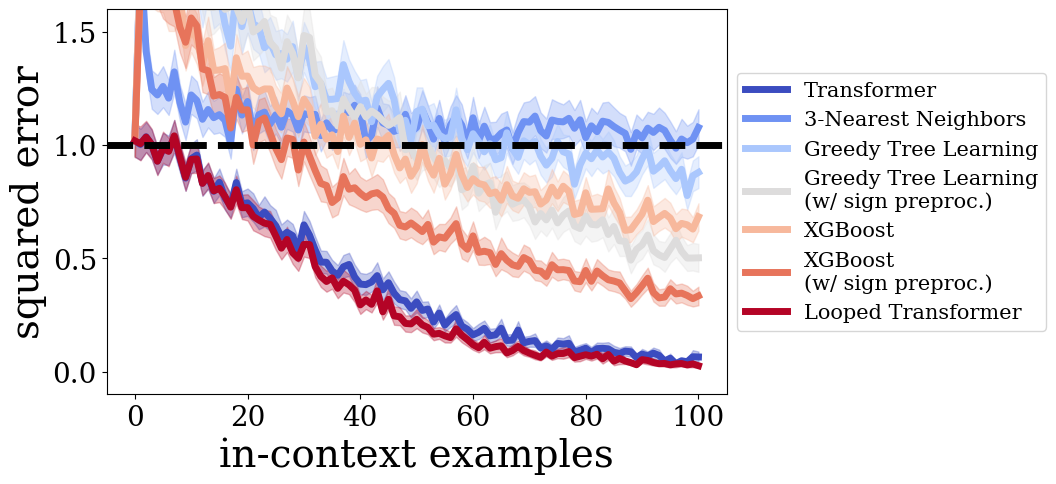

In [20]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("coolwarm")

result_name_list = ['Transformer', '3-Nearest Neighbors', 'decision_tree_max_depth=2', 'decision_tree_max_depth=4_pre_sign', 'xgboost_depth_4_lr_0.1_n_estimators_50', 'xgboost_depth_4_lr_0.1_n_estimators_50_pre_sign', 'Looped Transformer']

colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    if "decision_tree" in model_name:
        label_name = "Greedy Tree Learning"
    elif "xgb" in model_name:
        label_name = "XGBoost"
    else:
        label_name = model_name
    if "pre_sign" in model_name:
        label_name += "\n(w/ sign preproc.)"
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=label_name)
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.6)
# plt.xticks(np.arange(0, n_points))
plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])

plt.savefig("result_folder/Figures/DT_err.pdf", format='pdf', dpi=600, bbox_inches='tight')